In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

#### movieLens 100K 데이터 불러오기
* u.data : 영화평가(rating) 데이터
    * user_id : 사용자 id
    * movie_id : 영화 id
    * rating : 평점 (1~5)
    * timestamp : 평가한 연도/날짜/시간

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [3]:
# train set의 비율 75%, test set의 비율 25%
TRAIN_SIZE = 0.75
# 데이터를 무작위로 섞는다.
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [4]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        # user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성 과정
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        # num_users : 사용자 수, num_items(아이템 수)
        self.num_users, self.num_items = np.shape(self.R)
        # K : 잠재요인(Latent Fector)의 수
        self.K = K
        # alpha : Learning Rate
        self.alpha = alpha
        # beta : 정규화 계수
        self.beta = beta
        # iterations : 반복 횟수
        self.iterations = iterations
        # verbose : 중간 학습과정 출력 여부
        self.verbose = verbose

    # train set의 RMSE 계산
    # 현재의 P와 Q를 가지고 Root Mean Squared Error (RMSE) 계산
    def rmse(self):
        # 평점이 있는(0이 아닌) 요소의 인덱스
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            # 사용자 x, 아이템 y에 대해서 평점 예측치를 get_prediction()함수를 사용하여 계산
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            # 계산된 평점과 실제 값간의 오차를 errors리스트에 추가
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        # RMSE를 계산하여 반환
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Test set을 선정
    def set_test(self, ratings_test):
        # 분리된 test set을 넘겨받아 클래스 내부의 test_set을 만드는 함수
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            # 현재 사용자의 인덱스를 user_id_index에서 받아온다.
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            # 현재 아이템의 인덱스를 item_id_index에서 받아온다.
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            # 현재 사용자-아이템의 평점
            z = ratings_test.iloc[i, 2]
            # (사용자, 아이템, 평점)을 test_set에 추가
            test_set.append([x, y, z])
            # R을 사용해서 MF 모델을 학습하기 떄문에 test_set의 R을 제거
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        # test set에 있는 각각의 (사용자, 아이템, 평점)에 대해서 RMSE를 구한다.
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 100 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [5]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50, 261, 10):
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

K = 50
Iteration: 100 ; Train RMSE = 0.9013 ; Test RMSE = 0.9423
Iteration: 200 ; Train RMSE = 0.7503 ; Test RMSE = 0.9159
Iteration: 300 ; Train RMSE = 0.5544 ; Test RMSE = 0.9381
K = 60
Iteration: 100 ; Train RMSE = 0.9048 ; Test RMSE = 0.9436
Iteration: 200 ; Train RMSE = 0.7615 ; Test RMSE = 0.9180
Iteration: 300 ; Train RMSE = 0.5499 ; Test RMSE = 0.9361
K = 70
Iteration: 100 ; Train RMSE = 0.9053 ; Test RMSE = 0.9433
Iteration: 200 ; Train RMSE = 0.7674 ; Test RMSE = 0.9169
Iteration: 300 ; Train RMSE = 0.5485 ; Test RMSE = 0.9312
K = 80
Iteration: 100 ; Train RMSE = 0.9064 ; Test RMSE = 0.9434
Iteration: 200 ; Train RMSE = 0.7736 ; Test RMSE = 0.9145
Iteration: 300 ; Train RMSE = 0.5523 ; Test RMSE = 0.9250
K = 90
Iteration: 100 ; Train RMSE = 0.9070 ; Test RMSE = 0.9434
Iteration: 200 ; Train RMSE = 0.7822 ; Test RMSE = 0.9153
Iteration: 300 ; Train RMSE = 0.5568 ; Test RMSE = 0.9239
K = 100
Iteration: 100 ; Train RMSE = 0.9080 ; Test RMSE = 0.9438
Iteration: 200 ; Train RMSE =

In [10]:
# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

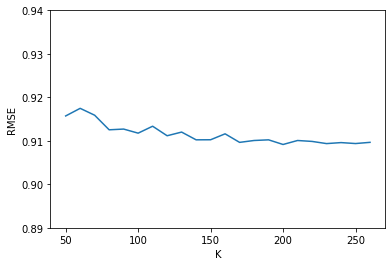

In [14]:
# K에 따른 RMSE 그래프
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

In [15]:
# 최적의 K와 iteration으로 모델 학습
RMSES = []
for K, iteration, RMSE in summary:
    RMSES.append(RMSE)
min = np.min(RMSES)
j = RMSES.index(min)
optimal_K = summary[j][0]
optimal_iteration = summary[j][1]

R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=optimal_K, alpha=0.001, beta=0.02, iterations=optimal_iteration, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

# Printing predictions
print(mf.full_prediction())
print(mf.get_one_prediction(1, 2))

Iteration: 100 ; Train RMSE = 0.9112 ; Test RMSE = 0.9444
Iteration: 200 ; Train RMSE = 0.8173 ; Test RMSE = 0.9176
[[3.53780618 3.17527362 3.00182095 ... 3.13186941 3.44279628 3.41034445]
 [3.80292465 3.39419002 3.01061765 ... 3.2774658  3.55333998 3.53185167]
 [3.49186469 2.8759052  2.57731216 ... 2.69800249 2.97644451 2.96144595]
 ...
 [4.24018646 3.79025141 3.53169452 ... 3.61682061 3.90450393 3.88497407]
 [4.66215159 4.02020744 3.61504046 ... 3.65319004 3.95507616 3.92863857]
 [4.02443555 3.59354924 2.95757597 ... 3.09778579 3.41519217 3.38144783]]
3.1752736165931346
